<a href="https://colab.research.google.com/github/brendanfoo/predict_refugee_count/blob/main/Log_IDPs_LR_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SUMMARY OF RESULTS (AFTER SCALING IDPs):**

Model | Specifications | Predict | Notes | Key Takeaways
------|----------------|---------|-------|---------------
LR | Log Scaled_IDP | Continuous | N/A | R squared (TRAIN) = 0.3232, R squared (TEST) = 0.2200
LR | Log Scaled_IDP, Log Population, Log Pop. Density, Log Infra | Continuous | N/A | R squared (TRAIN) = 0.3227, R squared (TEST) = 0.2533

**SUMMARY OF RESULTS (BEFORE SCALING IDPs):**

Model | Specifications | Predict | Notes | Key Takeaways
------|----------------|---------|-------|---------------
LR | Log IDPs | Continuous | N/A | R squared (TRAIN) = 0.415, R squared (TEST) = 0.240
LR | Log IDPs, Log Population, Log Population Density, Log Infra | Continuous | N/A | R squared (TRAIN) = 0.414, R squared (TEST) = 0.348

# Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import random
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Modelling
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics

# plots
import seaborn as sns
import matplotlib.pyplot as plt
tf.get_logger().setLevel('INFO')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
lr_log_idps = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/LRDATA.csv').iloc[:, 1:]
lr_log_idps.head()

,IDPs from Event,econ,gov,soc,cap,eco,exp,food,hab,health,...,8,9,10,11,12,Storms,DamBreak,Rain,Melting,TidesTsunami
0,3920.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3920.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1192.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1192.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,483.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Linear Regression: With Log IDPs

## Log Transformation of IDP Column

<Axes: ylabel='Density'>

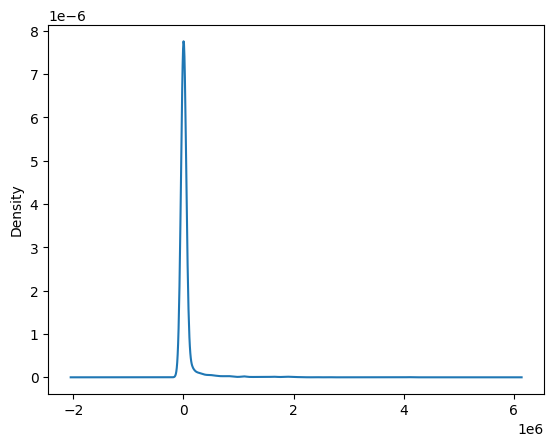

In [ ]:
# kde = kernel density estimation
# plot distribution of 'IDPs from Event' column values
lr_log_idps['Scaled_IDP'].plot(kind = 'kde')

In [ ]:
lr_log_idps['log_idps'] = np.log(lr_log_idps['Scaled_IDP'])
lr_log_idps.head()

,IDPs from Event,econ,gov,soc,cap,eco,exp,food,hab,health,...,9,10,11,12,Storms,DamBreak,Rain,Melting,TidesTsunami,log_idps
0,3920.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.661527
1,3920.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.493317
2,1192.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.472346
3,1192.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.302619
4,483.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.568345


<Axes: ylabel='Density'>

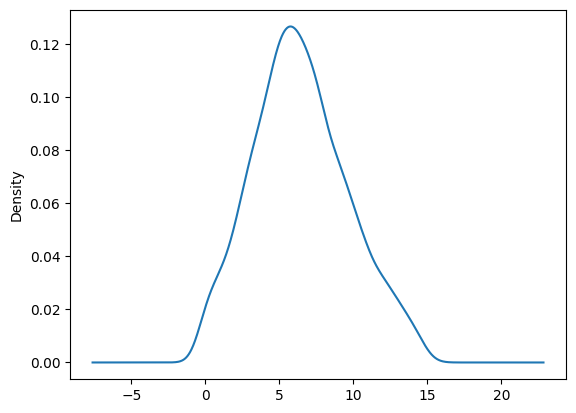

In [ ]:
# kde = kernel density estimation
# plot distribution of 'log_idps' column values
lr_log_idps['log_idps'].plot(kind = 'kde')

## Modeling: Predict Continuous

In [ ]:
np.set_printoptions(suppress=True)
# Drop 'IDPs from Event' column
lr_log_idps = lr_log_idps.drop(columns = ['IDPs from Event', 'Scaled_IDP'])

# Convert pandas dataframe into numpy array
matrix = np.array(lr_log_idps.values)

# Show first row of data
matrix[0:1,:]

array([[       0.13984363,        0.30811211,        0.18999024,
               0.73470737,        0.54613961,        0.54306345,
               0.57151278,        0.68037554,        0.58356817,
               0.29871879,        0.27377815,    12133.31      ,
               1.5       ,       14.        ,       12.44823228,
        27292819.        ,       21.9       ,    14473.        ,
               1.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        

In [ ]:
# Create numpy array with features
X = matrix[:,:-1]
print('Input:', X.shape)

# Create numpy array with labels
Y = matrix[:,-1]
print('Output:', Y.shape)

Input: (2622, 149)
Output: (2622,)


In [ ]:
# Features: All columns except 'log_idps'
X

array([[0.13984363, 0.30811211, 0.18999024, ..., 1.        , 0.        ,
        0.        ],
       [0.13984363, 0.30811211, 0.18999024, ..., 1.        , 0.        ,
        0.        ],
       [0.13984363, 0.30811211, 0.18999024, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.41382898, 0.39069593, 0.15028089, ..., 1.        , 0.        ,
        0.        ],
       [0.26026501, 0.24756759, 0.13198147, ..., 1.        , 0.        ,
        0.        ],
       [0.26026501, 0.24756759, 0.13198147, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
# Labels: Log transformation of 'Scaled_IDP' - 'log_idps'
Y

array([7.66152708, 7.49331725, 6.47234629, ..., 6.56948142, 3.55534806,
       6.8741985 ])

In [ ]:
# Split dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Print shapes of each
print('Training input:', X_train.shape)
print('Testing input:', X_test.shape)
print('Training output:', Y_train.shape)
print('Testing output:', Y_test.shape)

Training input: (2097, 149)
Testing input: (525, 149)
Training output: (2097,)
Testing output: (525,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

## RMSE

In [ ]:
# Calculate root mean square error (RMSE) for training and testing data
# Reminder: RMSE is an accuracy measure that measures the average difference
# between values predicted by model and the actual values

# Training data
N = len(Y_train)
rmse_train = np.sqrt(np.sum((np.array(Y_train).flatten() - np.array(predictions_train).flatten())**2)/N)
print("RMSE TRAIN: ", rmse_train)

# Testing data
N = len(Y_test)
rmse_test = np.sqrt(np.sum((np.array(Y_test).flatten() - np.array(predictions_test).flatten())**2)/N)
print("RMSE TEST: ", rmse_test)

RMSE TRAIN:  2.6150418691095783
RMSE TEST:  2.86939535562335


**Interpretation of the above RMSE's:**

- Since the RMSE of the TEST data is higher than that of the TRAIN data, there is overfitting in the model

In [ ]:
# Data range for 'log_idps' column
print('Minimum log_idps:', lr_log_idps['log_idps'].min())
print('Maximum log_idps:', lr_log_idps['log_idps'].max())
print('Mean log_idps:', lr_log_idps['log_idps'].mean())
print('Median log_idps:', lr_log_idps['log_idps'].median())

Minimum log_idps: 0.0
Maximum log_idps: 15.225345649000147
Mean log_idps: 6.430497954692071
Median log_idps: 6.214608098422191


**More interpretation of the RMSE's:**

- RMSE's calculated are pretty low relative to the data range for `log_idps` column -- a good sign

## Coefficients and R Squared

In [ ]:
from sklearn.metrics import r2_score

# Coefficients
print('Model coefficients:', model.coef_)
print(' ')

# R-squared
# Training data
print('R-squared TRAIN:', r2_score(Y_train, predictions_train))

# Testing data
print('R-squared TEST:', r2_score(Y_test, predictions_test))

Model coefficients: [ -0.48154831   6.82331421  -2.62232204   1.98627708  41.72747898
 -15.25030378   6.06966065  -6.34990884  25.12281193  36.33340489
 -40.57027272   0.00000082   0.77428533  -0.0012811    0.10999029
   0.          -0.00510173  -0.00000067  -7.74976399  -4.29499599
   3.60798192   5.3713355    5.73862727   0.          -0.
   2.5973883    1.75990936  -0.          -0.76120922   1.73817163
   4.36434177  -0.          -3.94784679   0.           5.6773807
   9.35120821   1.55567881  -2.12461931   0.          -0.6565982
   1.33567775  -0.          12.3839503    0.74542345  -0.22009512
  -2.33346819   6.01006564   8.56034223  -4.19902546  -6.06543548
   7.87786573  10.52879015  -5.67716348   1.23948952   0.
   5.73871995  -0.37909545  -6.05630429  -6.35457879   3.39398083
  -5.9068319    0.          -1.80357762  -6.10981469   1.81927843
   4.87360527   9.76459062   6.75563609   4.41425643   6.99674713
  -1.24455591  -1.75704053  -1.18733566  -0.          -0.23577294
  -4.045

**Interpretation of R-squared:**

- The lowest R-squared is 0 and means that the points are not explained by the regression whereas the highest R-squared is 1 and means that all the points are explained by the regression line
- Both R-squared values (of TRAIN and TEST sets) are rather low
- R-squared of 0.323 for the TRAIN data means that the regression explains 32.3% of the variation in our y-variable
- R-squared of 0.220 for the TEST data means that the regression explains 22.0% of the variation in our y-variable

## Prediction Label Comparison

In [ ]:
# Show prediction labels and compare with actual labels to see how good our prediction is

# Training dataset
print('Training Dataset')
train_true_pred_comparison = pd.DataFrame({'True log_idps': Y_train,
                                     'Predicted log_idps': predictions_train})
train_true_pred_comparison

Training Dataset


,True log_idps,Predicted log_idps
0,11.051239,7.071817
1,1.386294,3.782107
2,7.363914,5.322257
3,4.488636,5.859082
4,3.713572,5.917270
...,...,...
2092,4.564348,5.313944
2093,7.885705,5.360554
2094,12.717632,8.600166
2095,13.625560,10.826040


In [ ]:
# Testing dataset
print('Testing Dataset')
test_true_pred_comparison = pd.DataFrame({'True log_idps': Y_test,
                                     'Predicted log_idps': predictions_test})
test_true_pred_comparison

Testing Dataset


,True log_idps,Predicted log_idps
0,12.050033,6.858830
1,4.787492,5.643206
2,12.494659,9.265819
3,6.186209,5.771934
4,9.392662,8.658963
...,...,...
520,6.309918,6.201035
521,11.863716,7.882087
522,5.153292,4.309819
523,5.521461,4.000811


# Linear Regression: With Log IDPs, Log Population, Log Population Density, Log Infra

### Log Transformation of 4 Columns

- 'IDPs from Event' (already done earlier in notebook)
- 'Population'
- 'Population Density (People per Sq. Km.)'
- 'infra'

In [ ]:
log_idps_pop_infra = lr_log_idps.copy()
log_idps_pop_infra['log_pop'] = np.log(log_idps_pop_infra['Population'])
log_idps_pop_infra['log_pop_dens'] = np.log(log_idps_pop_infra['Population Density (People per Sq. Km.)'])
log_idps_pop_infra['log_infra'] = np.log(log_idps_pop_infra['infra'])

In [ ]:
log_idps_pop_infra.drop(columns = ['Population', 'Population Density (People per Sq. Km.)', 'infra'])
log_idps_pop_infra.head()

,econ,gov,soc,cap,eco,exp,food,hab,health,infra,...,12,Storms,DamBreak,Rain,Melting,TidesTsunami,log_idps,log_pop,log_pop_dens,log_infra
0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0.0,0.0,0.0,1.0,0.0,0.0,7.661527,17.122134,3.086487,-1.208253
1,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0.0,0.0,0.0,1.0,0.0,0.0,7.493317,17.122134,3.086487,-1.208253
2,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0.0,0.0,0.0,1.0,0.0,0.0,6.472346,17.122134,3.086487,-1.208253
3,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0.0,0.0,0.0,1.0,0.0,0.0,6.302619,17.122134,3.086487,-1.208253
4,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0.0,0.0,0.0,1.0,0.0,0.0,5.568345,17.122134,3.086487,-1.208253


### Modeling: Predict Continuous

In [ ]:
for col in log_idps_pop_infra.columns:
  print(col)

econ
gov
soc
cap
eco
exp
food
hab
health
infra
sens
Area
Severity
Duration
Magnitude
Population
Population Density (People per Sq. Km.)
Net international migrants, both sexes
AGO
ALB
ARG
AUS
AUT
BDI
BFA
BGD
BGR
BHS
BIH
BOL
BRA
BTN
BWA
CAF
CAN
CHE
CHL
CHN
CMR
COL
CRI
CUB
DEU
DOM
DZA
ECU
EGY
ESP
ETH
FJI
FRA
GBR
GEO
GHA
GIN
GRC
GTM
GUY
HND
HRV
HTI
HUN
IDN
IND
IRN
IRQ
ISR
ITA
JPN
KAZ
KEN
KHM
KOR
LBR
LKA
MAR
MDG
MEX
MKD
MLI
MMR
MNG
MOZ
MRT
MUS
MWI
MYS
NAM
NGA
NIC
NPL
NZL
OMN
PAK
PAN
PER
PHL
PNG
POL
PRK
PRT
PRY
ROU
RUS
RWA
SAU
SDN
SEN
SLB
SLE
SLV
SOM
SRB
SVK
TCD
THA
TJK
TUN
TUR
TZA
UGA
UKR
URY
USA
UZB
VCT
VEN
VNM
VUT
YEM
ZAF
ZMB
ZWE
2
3
4
5
6
7
8
9
10
11
12
Storms
DamBreak
Rain
Melting
TidesTsunami
log_idps
log_pop
log_pop_dens
log_infra


In [ ]:
target = log_idps_pop_infra[['log_idps']]
log_idps_pop_infra = log_idps_pop_infra.drop(columns = ['log_idps'])
log_idps_pop_infra['log_idps'] = target

In [ ]:
for col in log_idps_pop_infra.columns:
  print(col)

econ
gov
soc
cap
eco
exp
food
hab
health
infra
sens
Area
Severity
Duration
Magnitude
Population
Population Density (People per Sq. Km.)
Net international migrants, both sexes
AGO
ALB
ARG
AUS
AUT
BDI
BFA
BGD
BGR
BHS
BIH
BOL
BRA
BTN
BWA
CAF
CAN
CHE
CHL
CHN
CMR
COL
CRI
CUB
DEU
DOM
DZA
ECU
EGY
ESP
ETH
FJI
FRA
GBR
GEO
GHA
GIN
GRC
GTM
GUY
HND
HRV
HTI
HUN
IDN
IND
IRN
IRQ
ISR
ITA
JPN
KAZ
KEN
KHM
KOR
LBR
LKA
MAR
MDG
MEX
MKD
MLI
MMR
MNG
MOZ
MRT
MUS
MWI
MYS
NAM
NGA
NIC
NPL
NZL
OMN
PAK
PAN
PER
PHL
PNG
POL
PRK
PRT
PRY
ROU
RUS
RWA
SAU
SDN
SEN
SLB
SLE
SLV
SOM
SRB
SVK
TCD
THA
TJK
TUN
TUR
TZA
UGA
UKR
URY
USA
UZB
VCT
VEN
VNM
VUT
YEM
ZAF
ZMB
ZWE
2
3
4
5
6
7
8
9
10
11
12
Storms
DamBreak
Rain
Melting
TidesTsunami
log_pop
log_pop_dens
log_infra
log_idps


In [ ]:
log_idps_pop_infra = log_idps_pop_infra.drop(columns = ['infra', 'Population Density (People per Sq. Km.)', 'Population'])

In [ ]:
# Convert pandas dataframe into numpy array
matrix = np.array(log_idps_pop_infra.values)

# Create numpy array with features
X = matrix[:,:-1]
print('Input:', X.shape)

# Create numpy array with labels
Y = matrix[:,-1]
print('Output:', Y.shape)

Input: (2622, 149)
Output: (2622,)


In [ ]:
# Split dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Print shapes of each
print('Training input:', X_train.shape)
print('Testing input:', X_test.shape)
print('Training output:', Y_train.shape)
print('Testing output:', Y_test.shape)

Training input: (2097, 149)
Testing input: (525, 149)
Training output: (2097,)
Testing output: (525,)


In [ ]:
X

array([[ 0.13984363,  0.30811211,  0.18999024, ..., 17.12213419,
         3.08648664, -1.20825266],
       [ 0.13984363,  0.30811211,  0.18999024, ..., 17.12213419,
         3.08648664, -1.20825266],
       [ 0.13984363,  0.30811211,  0.18999024, ..., 17.12213419,
         3.08648664, -1.20825266],
       ...,
       [ 0.41382898,  0.39069593,  0.15028089, ..., 16.73454455,
         3.2148678 , -1.1039955 ],
       [ 0.26026501,  0.24756759,  0.13198147, ..., 16.57474564,
         3.70868208, -1.20473086],
       [ 0.26026501,  0.24756759,  0.13198147, ..., 16.57474564,
         3.70868208, -1.20473086]])

In [ ]:
Y

array([7.66152708, 7.49331725, 6.47234629, ..., 6.56948142, 3.55534806,
       6.8741985 ])

In [ ]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

### RMSE

In [ ]:
# Calculate root mean square error (RMSE) for training and testing data
# Reminder: RMSE is an accuracy measure that measures the average difference
# between values predicted by model and the actual values

# Training data
N = len(Y_train)
rmse_train = np.sqrt(np.sum((np.array(Y_train).flatten() - np.array(predictions_train).flatten())**2)/N)
print("RMSE TRAIN: ", rmse_train)

# Testing data
N = len(Y_test)
rmse_test = np.sqrt(np.sum((np.array(Y_test).flatten() - np.array(predictions_test).flatten())**2)/N)
print("RMSE TEST: ", rmse_test)

RMSE TRAIN:  2.6160173144774186
RMSE TEST:  2.8075022802189635


In [ ]:
# Data range for 'log_idps' column
print('Minimum log_idps:', log_idps_pop_infra['log_idps'].min())
print('Maximum log_idps:', log_idps_pop_infra['log_idps'].max())
print('Mean log_idps:', log_idps_pop_infra['log_idps'].mean())
print('Median log_idps:', log_idps_pop_infra['log_idps'].median())

Minimum log_idps: 0.0
Maximum log_idps: 15.225345649000147
Mean log_idps: 6.430497954692071
Median log_idps: 6.214608098422191


### Coefficients and R Squared

In [ ]:
# Coefficients
print('Model coefficients:', model.coef_)
print(' ')

# R-squared
# Training data
print('R-squared TRAIN:', r2_score(Y_train, predictions_train))

# Testing data
print('R-squared TEST:', r2_score(Y_test, predictions_test))

Model coefficients: [ -0.49569128   6.29265824  -2.78364131  31.91070909  18.60414228
  -8.7851088   -7.96377855 -17.10368641   9.99502053  -6.26287084
   0.00000085   0.79663137  -0.00149685   0.10822332  -0.00000069
  -5.56721634  -3.38495707   5.34366833   9.31968435   4.61978691
  -0.           0.          -3.64603985   2.56336307  -0.
  -0.55787503  -0.62870267   9.11794502  -0.          -7.07682111
  -0.          10.05964528   5.66529433   2.03678067   3.75084705
  -0.           1.63204562   2.00839297   0.           9.0548871
  -0.82865918  -0.84324576   0.29499454   2.49746627   8.10687351
  -5.53361885  -4.45697415   7.63464775   8.4317911   -4.66405717
   1.2865567    0.           6.43440271   0.6496073   -6.35446325
  -6.00185429   1.46082444  -8.30685728   0.          -0.67206957
  -1.99261636   2.2008808    5.06042809   4.0778474    7.29704623
   6.68270825   8.32319979  -2.49631978  -6.49406548  -0.80725508
  -0.          -3.11659236  -4.03964131 -10.44931952   3.72154252

### Prediction Label Comparison

In [ ]:
# Show prediction labels and compare with actual labels to see how good our prediction is

# Training dataset
print('Training Dataset')
train_true_pred_comparison = pd.DataFrame({'True log_idps': Y_train,
                                     'Predicted log_idps': predictions_train})
train_true_pred_comparison

Training Dataset


,True log_idps,Predicted log_idps
0,11.051239,7.131350
1,1.386294,3.870148
2,7.363914,5.286678
3,4.488636,5.852617
4,3.713572,5.920349
...,...,...
2092,4.564348,5.276271
2093,7.885705,5.317765
2094,12.717632,8.509146
2095,13.625560,10.840512


In [ ]:
# Testing dataset
print('Testing Dataset')
test_true_pred_comparison = pd.DataFrame({'True log_idps': Y_test,
                                     'Predicted log_idps': predictions_test})
test_true_pred_comparison

Testing Dataset


,True log_idps,Predicted log_idps
0,12.050033,6.846404
1,4.787492,5.677417
2,12.494659,9.390258
3,6.186209,5.701537
4,9.392662,8.589748
...,...,...
520,6.309918,6.172002
521,11.863716,8.037206
522,5.153292,4.292249
523,5.521461,3.977362
